**Setup and Data collection**

In [11]:

import seaborn as sns

# Set a consistent style for the plots
sns.set_style("whitegrid")


import gdown, pandas as pd, numpy as np, os

import os

CANDIDATE = "ravina_karmankar"   # change to your name
ROOT = f"ds_{CANDIDATE}"

os.makedirs(ROOT, exist_ok=True)
os.makedirs(f"{ROOT}/csv_files", exist_ok=True)
os.makedirs(f"{ROOT}/outputs", exist_ok=True)

print("Root directory and subfolders created:", ROOT)

# File IDs
hl_file_id = "historical_data.csv"
fg_file_id = "fear_greed_index.csv"

# Convert IDs to full URLs
hl_url = f"https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view?usp=sharing"
fg_url = f"https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view?usp=sharing"

# Paths
hl_path = f"{ROOT}/csv_files/historical_trader_data.csv"
fg_path = f"{ROOT}/csv_files/fear_greed.csv"

# Download
gdown.download(url=hl_url, output=hl_path, quiet=False, fuzzy=True)
gdown.download(url=fg_url, output=fg_path, quiet=False, fuzzy=True)

# Read & preview
hl_df = pd.read_csv(hl_path)
fg_df = pd.read_csv(fg_path)

print("Historical Trader Data:", hl_df.shape)
print(hl_df.head(), "\n")
print("Fear & Greed Index:", fg_df.shape)
print(fg_df.head())


Root directory and subfolders created: ds_ravina_karmankar


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_ravina_karmankar/csv_files/historical_trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_ravina_karmankar/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 3.13MB/s]


Historical Trader Data: (211224, 16)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash   

**Data Preparation and Feature engineering**

In [13]:

# Handle the dates and times for both datasets
fg_df['date'] = pd.to_datetime(fg_df['date'])
fg_df = fg_df.set_index('date').sort_index()

# Convert 'Timestamp IST' to a proper datetime format
hl_df['Timestamp IST'] = pd.to_datetime(hl_df['Timestamp IST'], format='%d-%m-%Y %H:%M', dayfirst=True)
hl_df = hl_df.set_index('Timestamp IST').sort_index()

# Rename columns for easier handling
hl_df = hl_df.rename(columns={
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Start Position Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Account': 'account',
})

# Feature Engineering on trader data
hl_df['trade_volume'] = hl_df['execution_price'] * hl_df['size_tokens']
hl_df['profit_loss'] = hl_df['closed_pnl']

# Aggregate trader data to a daily level to match the sentiment data
daily_trader_metrics = hl_df.resample('D').agg(
    daily_volume=('trade_volume', 'sum'),
    net_pnl=('profit_loss', 'sum'),
    trade_count=('account', 'count')
)

daily_trader_metrics['avg_pnl_per_trade'] = daily_trader_metrics['net_pnl'] / daily_trader_metrics['trade_count']
daily_trader_metrics['risk_std_pnl'] = hl_df['closed_pnl'].resample('D').std()

# Correctly calculate long and short volume for the ratio
daily_trader_metrics['total_long_size'] = hl_df[hl_df['side'] == 'BUY'].resample('D')['size_tokens'].sum()
daily_trader_metrics['total_short_size'] = hl_df[hl_df['side'] == 'SELL'].resample('D')['size_tokens'].sum()
daily_trader_metrics['long_short_ratio'] = daily_trader_metrics['total_long_size'] / daily_trader_metrics['total_short_size']

# Replace infinite values with NaN to avoid plotting issues
daily_trader_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Merge the datasets. Use a common date index.
combined_df = pd.merge(fg_df, daily_trader_metrics, left_index=True, right_index=True, how='inner')

print("\nPrepared Combined Daily DataFrame:")
print(combined_df.head())
print("\nCombined DataFrame Info:")
combined_df.info()



Prepared Combined Daily DataFrame:
             timestamp  value classification  daily_volume  net_pnl  \
2023-05-01  1682919000     63          Greed     476.99281      0.0   
2023-05-02  1683005400     55          Greed       0.00000      0.0   
2023-05-03  1683091800     64          Greed       0.00000      0.0   
2023-05-04  1683178200     64          Greed       0.00000      0.0   
2023-05-05  1683264600     61          Greed       0.00000      0.0   

            trade_count  avg_pnl_per_trade  risk_std_pnl  total_long_size  \
2023-05-01            3                0.0           0.0           0.2513   
2023-05-02            0                NaN           NaN           0.0000   
2023-05-03            0                NaN           NaN           0.0000   
2023-05-04            0                NaN           NaN           0.0000   
2023-05-05            0                NaN           NaN           0.0000   

            total_short_size  long_short_ratio  
2023-05-01               

**Exploratory Data Analysis (EDA) and Visualization**

***A. Behavior Metrics vs. Market Sentiment Classification***


Aggregated Metrics by Sentiment Classification:
                daily_volume       net_pnl  risk_std_pnl  long_short_ratio
classification                                                            
Extreme Fear    7.632284e+06  49274.016566    729.867572          2.858929
Extreme Greed   1.072976e+06  23406.649230    278.656985          2.941669
Fear            3.746704e+06  26024.460788    351.688431       2600.728804
Greed           9.815731e+05   7313.364874    247.820567        600.474658
Neutral         1.018317e+06   7304.636585    292.949624        172.232344


/tmp/ipython-input-3775292794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_grouped_sorted.index, y=sentiment_grouped_sorted[metric], ax=axes.flatten()[i], palette='viridis')
/tmp/ipython-input-3775292794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_grouped_sorted.index, y=sentiment_grouped_sorted[metric], ax=axes.flatten()[i], palette='viridis')
/tmp/ipython-input-3775292794.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_grouped_sorted.index, y=sentiment_grouped_sorted[metric], ax=axe

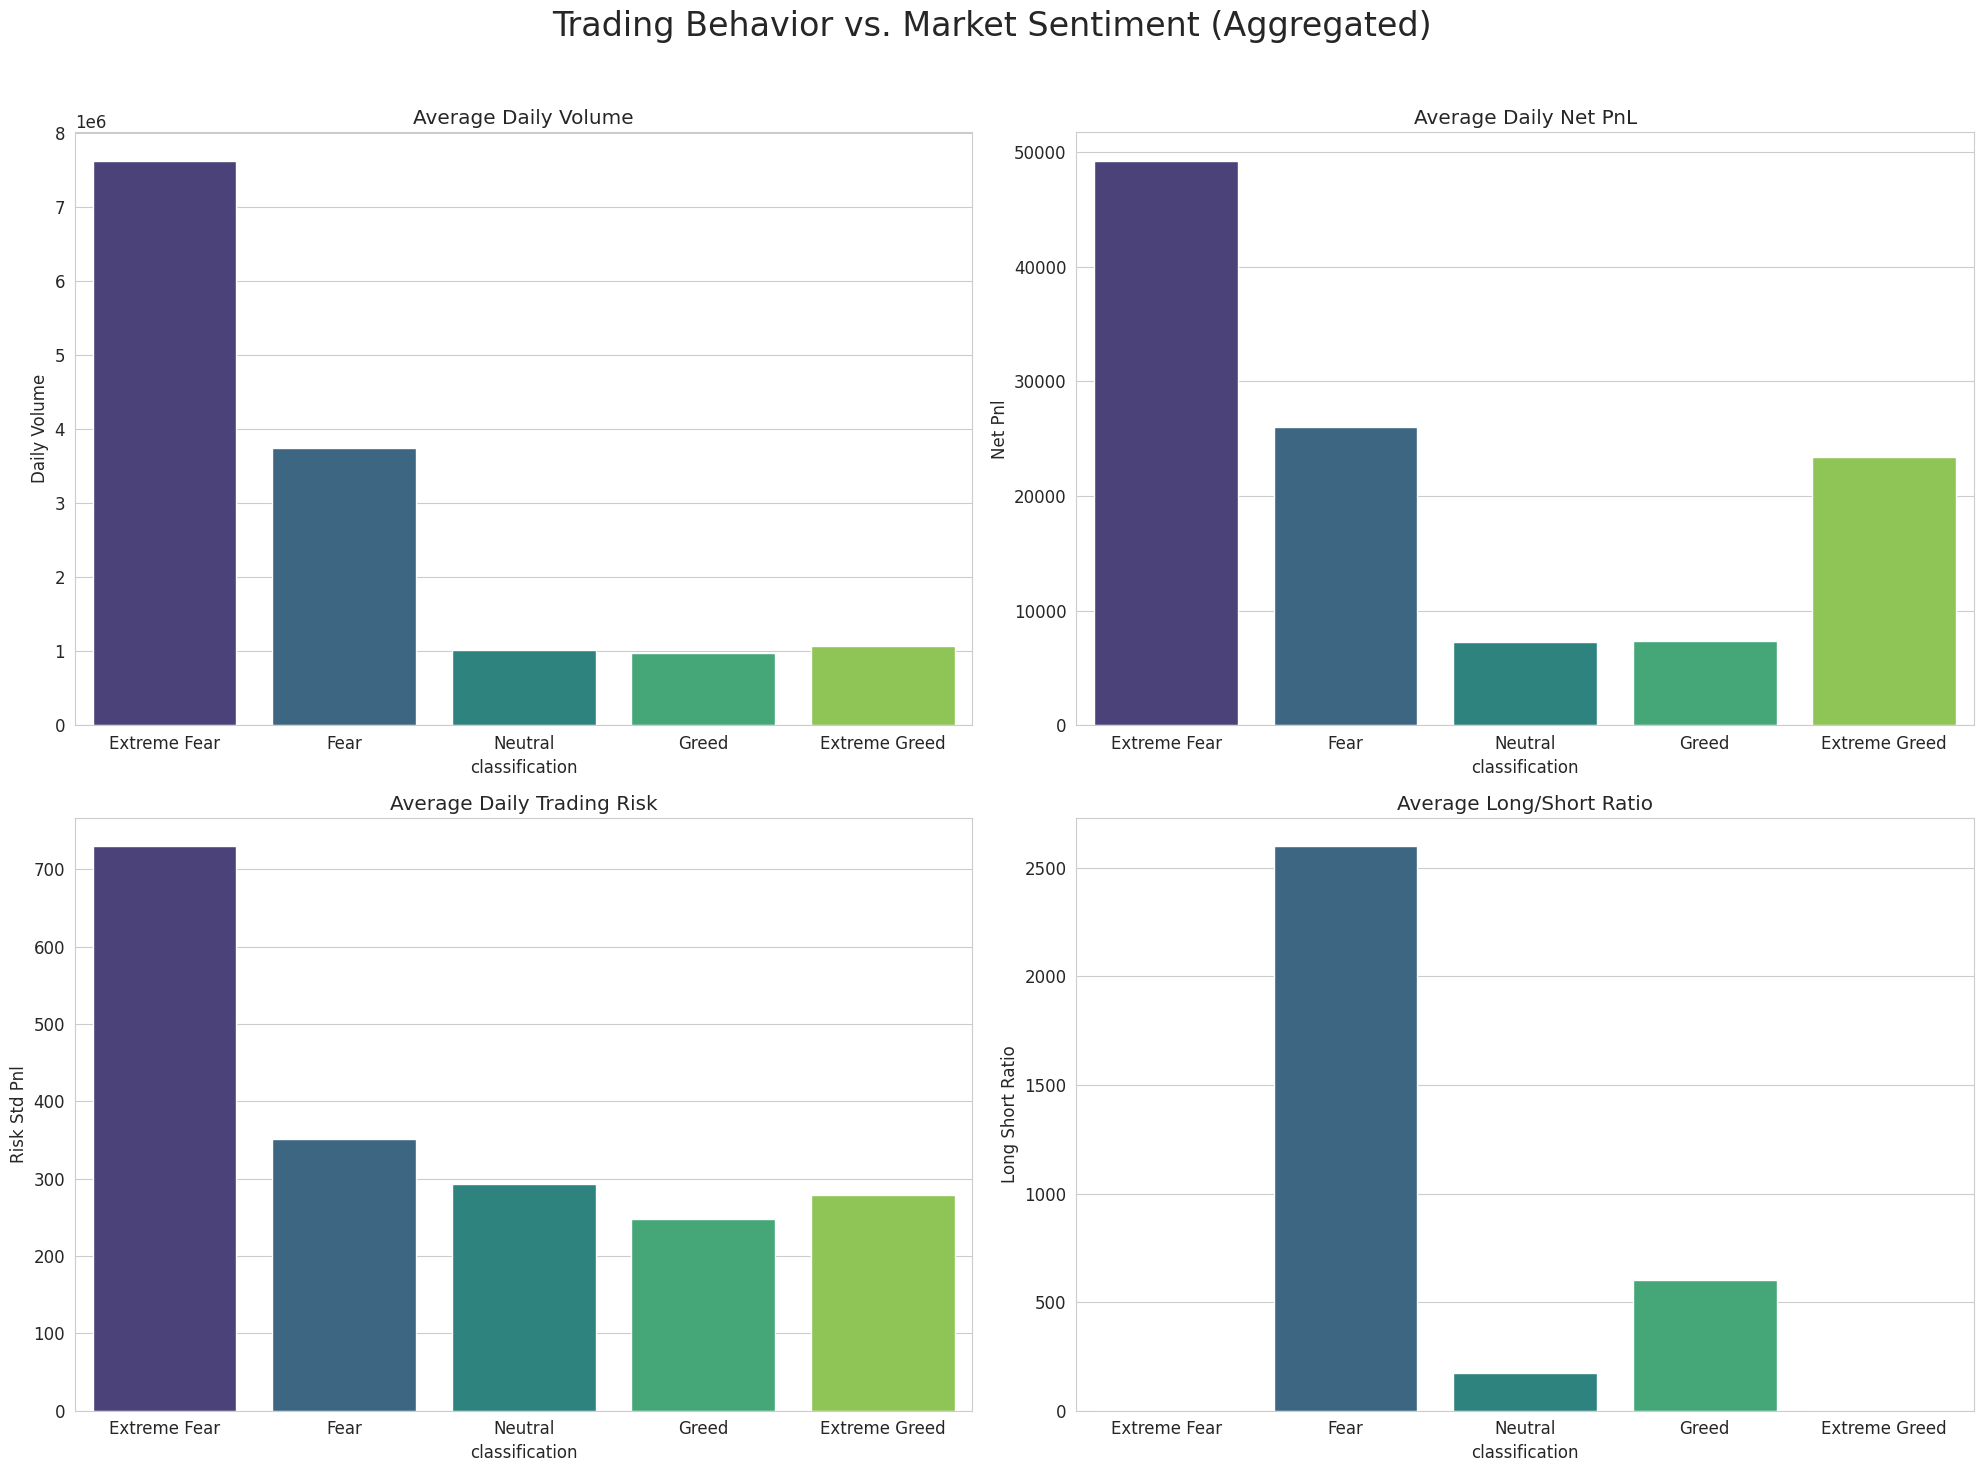

In [14]:


# Set a consistent style for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

print("\nAggregated Metrics by Sentiment Classification:")
sentiment_grouped = combined_df.groupby('classification').mean(numeric_only=True)
print(sentiment_grouped[['daily_volume', 'net_pnl', 'risk_std_pnl', 'long_short_ratio']])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.suptitle('Trading Behavior vs. Market Sentiment (Aggregated)', fontsize=24)
plot_metrics = ['daily_volume', 'net_pnl', 'risk_std_pnl', 'long_short_ratio']
titles = ['Average Daily Volume', 'Average Daily Net PnL', 'Average Daily Trading Risk', 'Average Long/Short Ratio']
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_grouped_sorted = sentiment_grouped.reindex(sentiment_order)


for i, metric in enumerate(plot_metrics):
    sns.barplot(x=sentiment_grouped_sorted.index, y=sentiment_grouped_sorted[metric], ax=axes.flatten()[i], palette='viridis')
    axes.flatten()[i].set_title(titles[i])
    axes.flatten()[i].set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{ROOT}/outputs/sentiment_behavior_barplot.png')
plt.show()

***B. Time Series Analysis for Divergence***

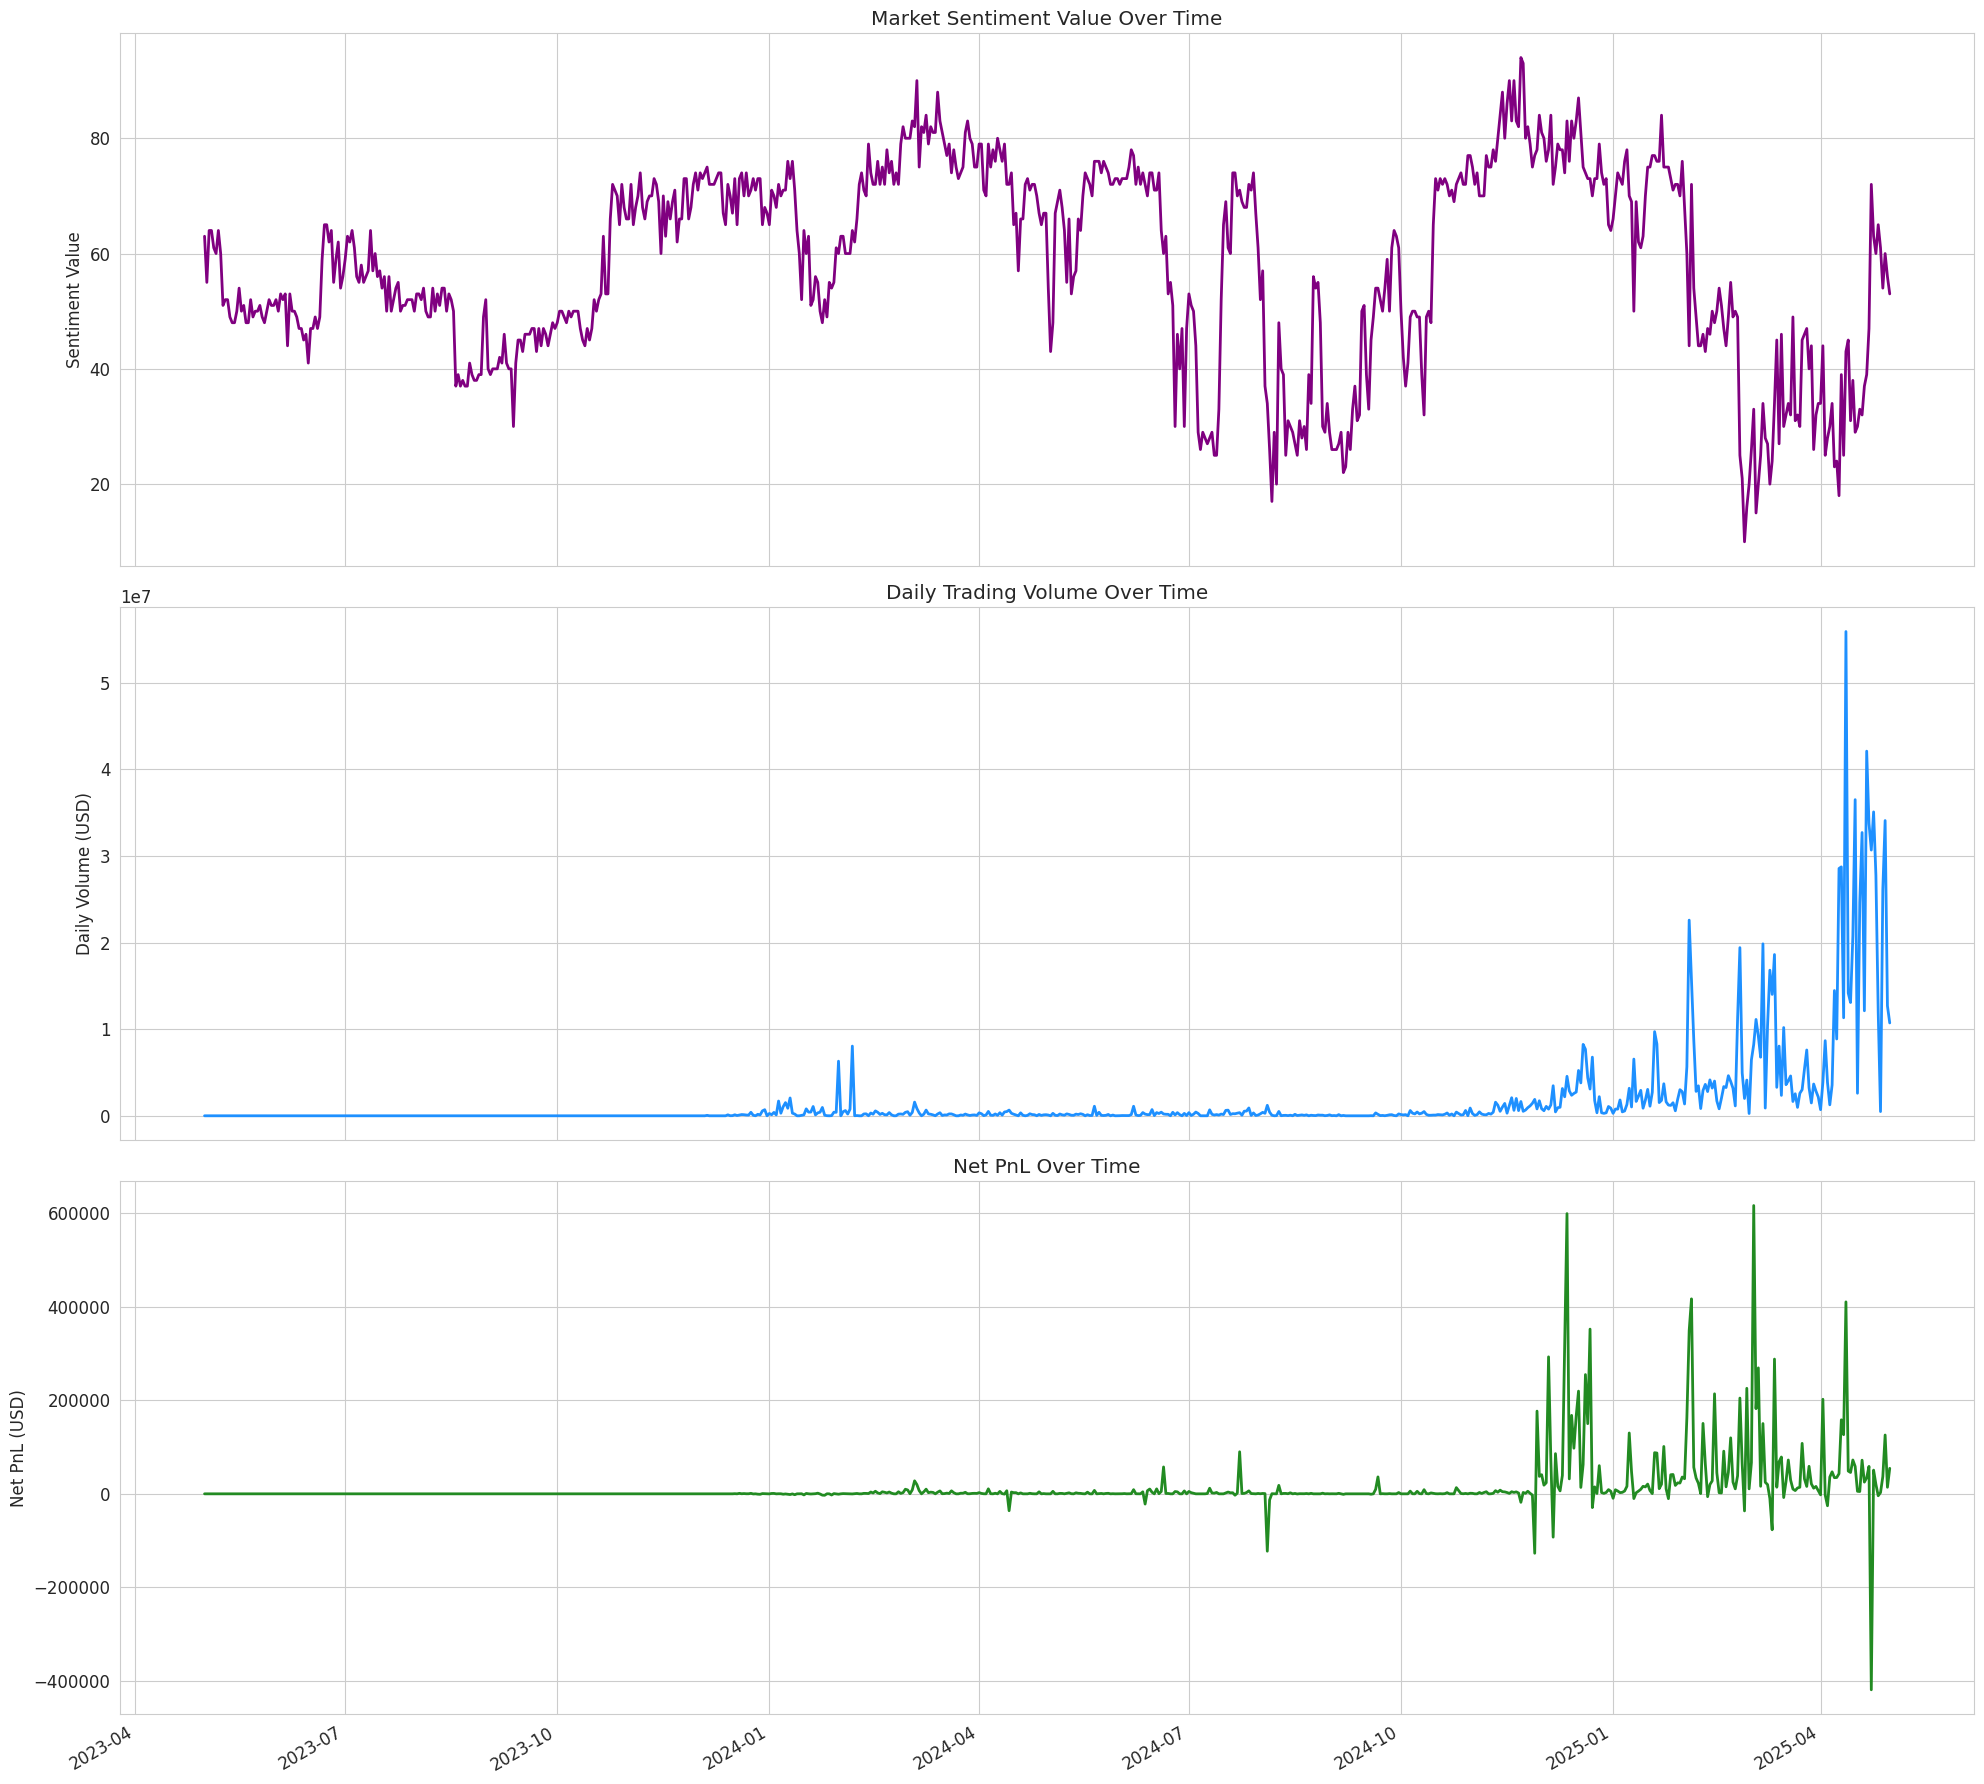

In [15]:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18), sharex=True)

combined_df['value'].plot(ax=axes[0], title='Market Sentiment Value Over Time', color='purple', linewidth=2)
combined_df['daily_volume'].plot(ax=axes[1], title='Daily Trading Volume Over Time', color='dodgerblue', linewidth=2)
combined_df['net_pnl'].plot(ax=axes[2], title='Net PnL Over Time', color='forestgreen', linewidth=2)

axes[0].set_ylabel('Sentiment Value')
axes[1].set_ylabel('Daily Volume (USD)')
axes[2].set_ylabel('Net PnL (USD)')

plt.tight_layout()
plt.savefig(f'{ROOT}/outputs/time_series_analysis.png')
plt.show()



***C. Deep Dive into PnL Distribution***

/tmp/ipython-input-2650099858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='net_pnl', data=combined_df, palette='viridis', order=sentiment_order)


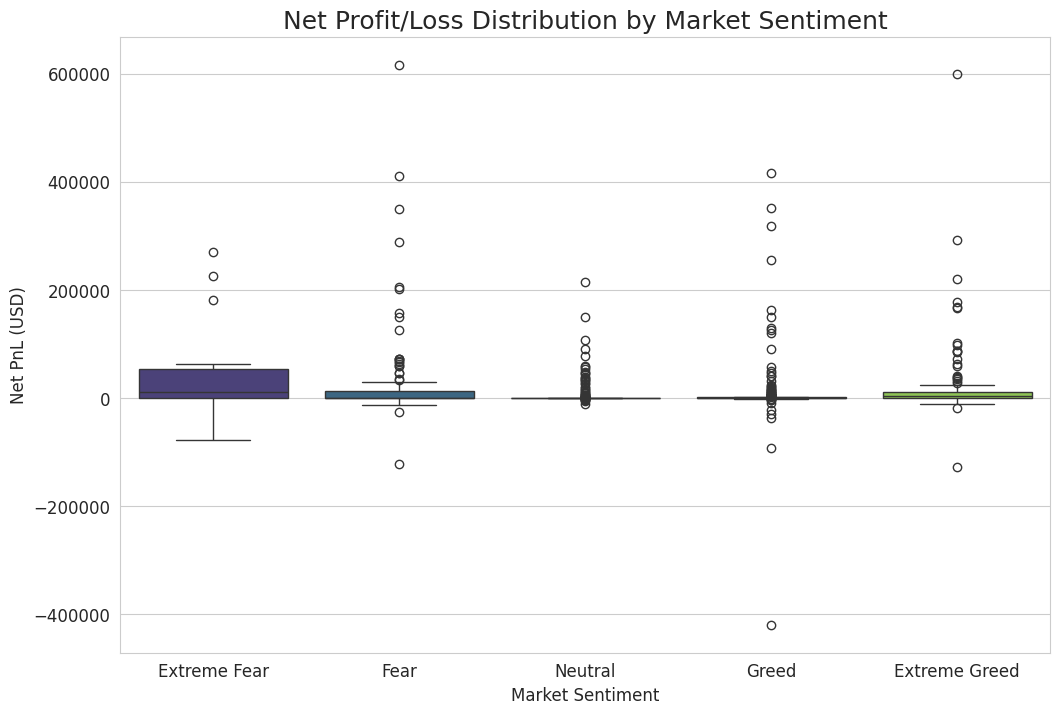

In [16]:

plt.figure(figsize=(12, 8))
sns.boxplot(x='classification', y='net_pnl', data=combined_df, palette='viridis', order=sentiment_order)
plt.title('Net Profit/Loss Distribution by Market Sentiment', fontsize=18)
plt.xlabel('Market Sentiment')
plt.ylabel('Net PnL (USD)')
plt.savefig(f'{ROOT}/outputs/pnl_distribution_boxplot.png')
plt.show()



***D. Long/Short Volume Ratio Analysis***

/tmp/ipython-input-2966427914.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='long_short_ratio', data=combined_df, palette='viridis', order=sentiment_order)


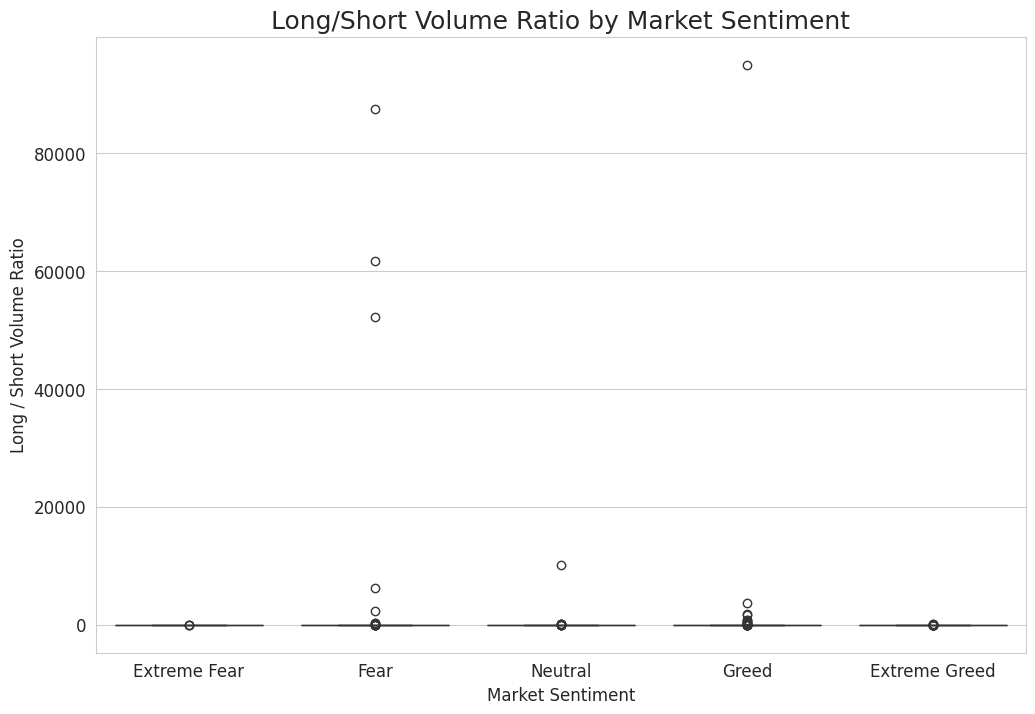

In [17]:
# D. Long/Short Volume Ratio Analysis
plt.figure(figsize=(12, 8))
# Note: Infinities were handled earlier, so this plot should work fine
sns.boxplot(x='classification', y='long_short_ratio', data=combined_df, palette='viridis', order=sentiment_order)
plt.title('Long/Short Volume Ratio by Market Sentiment', fontsize=18)
plt.xlabel('Market Sentiment')
plt.ylabel('Long / Short Volume Ratio')
plt.savefig(f'{ROOT}/outputs/long_short_ratio_boxplot.png')
plt.show()

In [19]:
!ls -R ds_ravina_karmankar

ds_ravina_karmankar:
csv_files  outputs

ds_ravina_karmankar/csv_files:
fear_greed.csv	historical_trader_data.csv

ds_ravina_karmankar/outputs:
long_short_ratio_boxplot.png  sentiment_behavior_barplot.png
pnl_distribution_boxplot.png  time_series_analysis.png
